# DTSA 5509 Supervised Learning Final Project
By Bianca Verlangieri, October 9, 2022

### Step 1: Gather data, determine the method of data collection and provenance of the data
In my final project, I'm going to use the US COVID-19 dataset from the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. This data set is published on their GitLab repository. It includes some aggregate data sources, like World Health Organization, and some US data sources, like data directly from states and their counties. Specifically, I am going to use the time series data on this site, which includes daily time series summary tables, with information such as number of COVID-19 deaths and cases from different US states and counties. To make it easier for this project to be reproduced (and avoid uploading large files), I am going to grab the data directly from the website.

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np

# Read in data from gitlab
data_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
data_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# Look at a snippet of the data (first 5 rows)
data_deaths.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/30/22,10/1/22,10/2/22,10/3/22,10/4/22,10/5/22,10/6/22,10/7/22,10/8/22,10/9/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,227,227,227,227,227,227,228,228,228,228
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,712,712,712,712,712,712,714,714,714,714
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,103,103,103,103,103,103,103,103,103,103
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,107,107,107,107,107,107,108,108,108,108
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,258,258,258,258,258,258,258,258,258,258


### Step 2: Identify a Supervised Machine Learning Problem
In this project, I am going to use the COVID-19 deaths and cases data across the US and determine if there is a linear relationship using linear regression, a type of supervised machine learning. I am going to test to see if COVID-19 deaths can be predicted linearly from COVID-19 cases, across the US. Also, I am going to inspect the data distribution across other features, such as states and counties. This is similar work as has been done by other sources and as to what has been discussed in the news in recent years.

### Step 3: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
These data sets have many columns (1003) and many rows (over 3000). The large number of columns or features is primarily because the dates are split up into different columns. In the next section of code we'll clean these up. Each date just represents updated data (aggregated from previous days), so let's just look at the most recent day and drop the other date columns for now. If you wanted to do more time trending analysis, you would need to keep all of the date information, to see how cases and deaths trended over time.

In [2]:
# Drop all date columns except latest one for deaths data
for col in data_deaths.columns:
    if '10/8/22' in col:
        pass
    elif '/' in col:
        del data_deaths[col]

# Rename remaining columns with '/' to use '_' so they are more easily accessible
data_deaths.columns = [f.replace("/", "_").replace(" ", "_") for f in data_deaths.columns]

# Rename date column to total number of deaths
data_deaths.rename(columns = {'10_8_22':'deaths'}, inplace = True)
print(data_deaths.columns.values)

['UID' 'iso2' 'iso3' 'code3' 'FIPS' 'Admin2' 'Province_State'
 'Country_Region' 'Lat' 'Long_' 'Combined_Key' 'Population' 'deaths']


In [3]:
# Drop all date columns except latest one for cases data
for col in data_cases.columns:
    if '10/8/22' in col:
        pass
    elif '/' in col:
        del data_cases[col]

# Rename remaining columns with '/' to use '_' so they are more easily accessible
data_cases.columns = [f.replace("/", "_").replace(" ", "_") for f in data_cases.columns]

# Rename date column to total number of cases
data_cases.rename(columns = {'10_8_22':'cases'}, inplace = True)
print(data_cases.columns.values)

['UID' 'iso2' 'iso3' 'code3' 'FIPS' 'Admin2' 'Province_State'
 'Country_Region' 'Lat' 'Long_' 'Combined_Key' 'cases']


Now, let's do some additional cleanup of the data. Let's merge these dataframes into 1 and keep deaths and cases as separate columns. Pandas will merge across common features, like Admin2. These two data sets have the same number of rows, so it will be easy to merge. Then, let's look to see how many null values are in the merged dataframe by column.

In [4]:
# Merge dataframes
df = pd.merge(data_deaths, data_cases)

# Compute percentage of data that is nulls for each remaining column
for c in df.columns:
    percent_null = df[c].isnull().sum()/len(df[c])
    print(c, percent_null)

UID 0.0
iso2 0.0
iso3 0.0
code3 0.0
FIPS 0.002992220227408737
Admin2 0.0017953321364452424
Province_State 0.0
Country_Region 0.0
Lat 0.0
Long_ 0.0
Combined_Key 0.0
Population 0.0
deaths 0.0
cases 0.0


The only columns with nulls are the FIPS and the Admin2 columns. FIPS identifies counties, but we already have that in the Admin2 column which specifies county names. Since the number of null values is small (less than 5%), let's just drop the rows with these null values. We could consider replacing these null values with something like the mode or most common value in the column, but that wouldn't be accurate data. Since these percentages are small, and we have plenty of rows to use, it's best to just drop the rows that contain null values. Let's also drop columns that are not of interest to us, like FIPS (same as Admin2) and Country Region (all data is U.S. data, so this doesn't add any information for us).

In [5]:
# Drop a few columns
del df['FIPS']
del df['Country_Region']

# Drop rows with null values (also, print out number of rows before and after to make sure it worked)
print(len(df))
df = df.dropna()
print(len(df))

3342
3336


Let's look at a summary of the data now that we've cleaned it up, and inspect the data types. This will help us determine what kind of machine learning we can do on the data. Some of the variables will be categorical (shown as object type), and some will be integer values (like latitude and longitude which is in degrees). Things like state, county (Admin2), and population might be of interest to us when paired with number of cases and deaths. Let's visualize that data first.

In [6]:
# Print out summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3336 entries, 0 to 3341
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UID             3336 non-null   int64  
 1   iso2            3336 non-null   object 
 2   iso3            3336 non-null   object 
 3   code3           3336 non-null   int64  
 4   Admin2          3336 non-null   object 
 5   Province_State  3336 non-null   object 
 6   Lat             3336 non-null   float64
 7   Long_           3336 non-null   float64
 8   Combined_Key    3336 non-null   object 
 9   Population      3336 non-null   int64  
 10  deaths          3336 non-null   int64  
 11  cases           3336 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 338.8+ KB


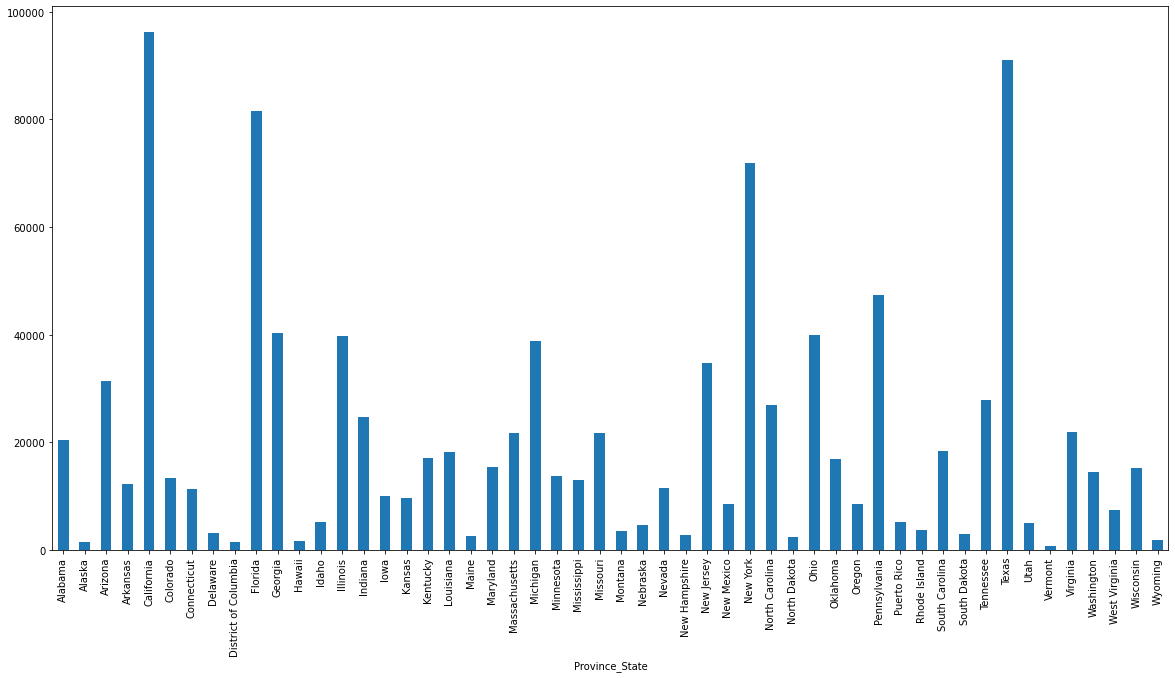

In [7]:
# Visualize the features/columns of interest
# Plot COVID-19 deaths per state
deaths_per_state = df.groupby('Province_State')['deaths'].sum()
fig = deaths_per_state.plot(kind='bar',figsize=(20, 10))

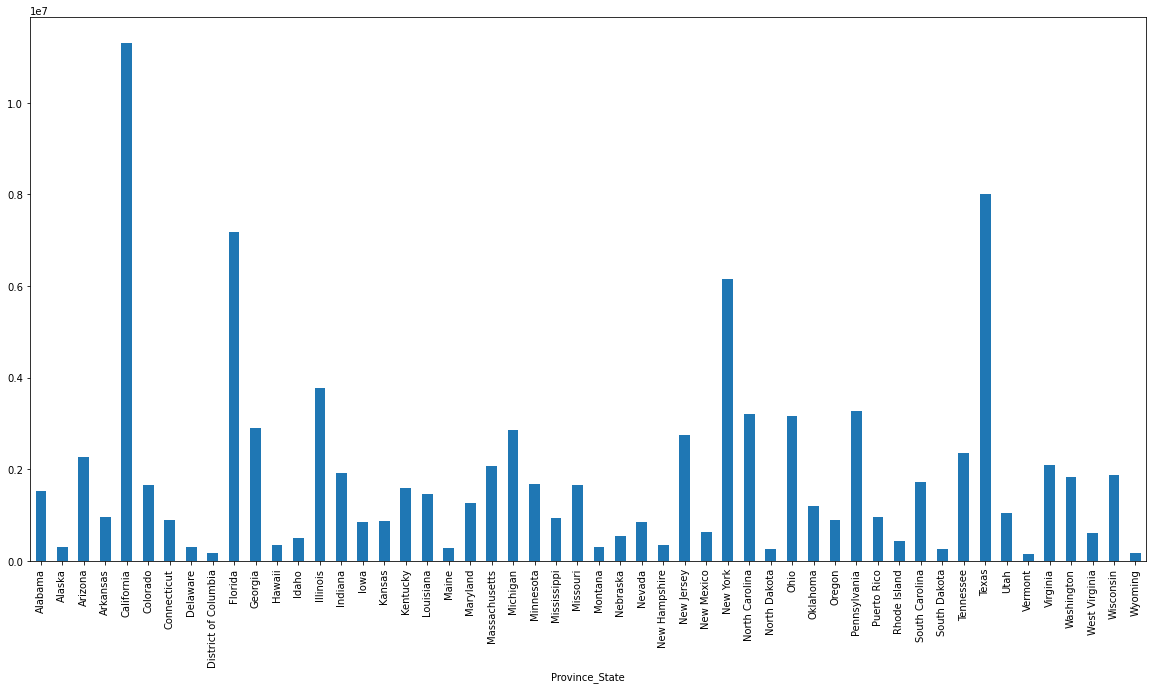

In [144]:
# Plot COVID-19 cases per state
cases_per_state = df.groupby('Province_State')['cases'].sum()
fig = cases_per_state.plot(kind='bar',figsize=(20, 10))

From these bar plots, it looks like big states like California and Texas have the most reported COVID-19 cases and deaths. This makes sense with what has been heard in the news, and makes sense with their big populations. Let's confirm that big population states also have a high number of cases and deaths, generally.

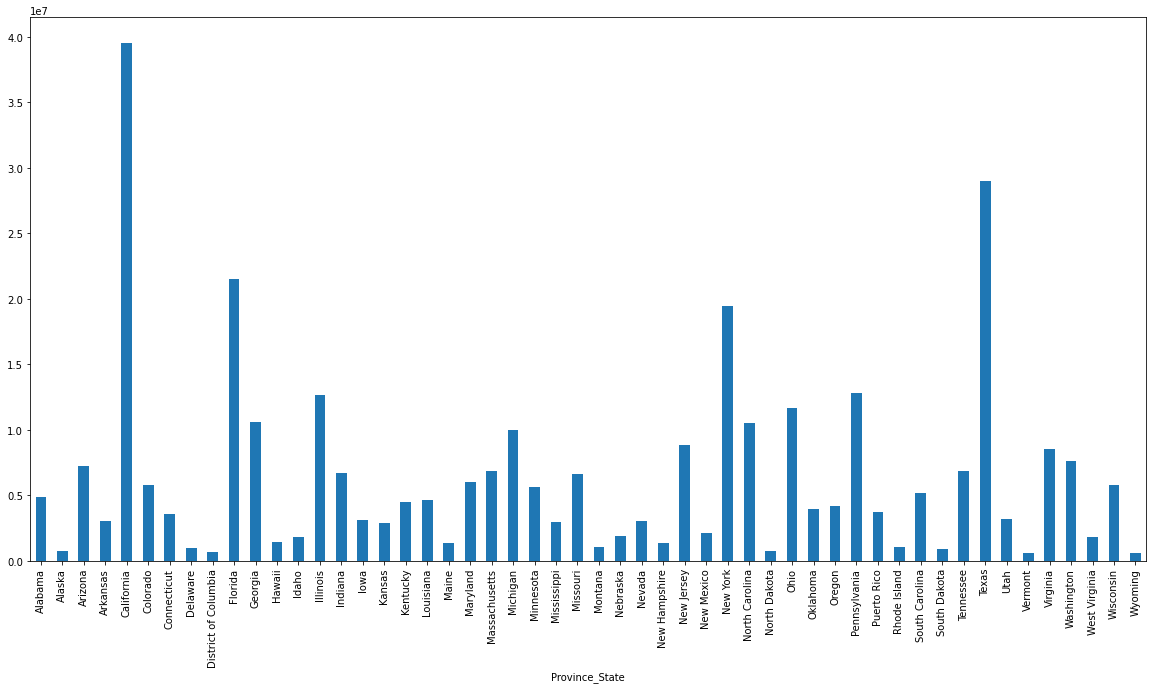

In [8]:
# Plot population per state
pop_per_state = df.groupby('Province_State')['Population'].sum()
fig = pop_per_state.plot(kind='bar',figsize=(20, 10))

The plot above confirms our theory. We can take this one step further, and add new columns, deaths per hundred and cases per hundred, which normalize those variables by the population. This way, we can see which states have the largest density of deaths and cases, independent of population.

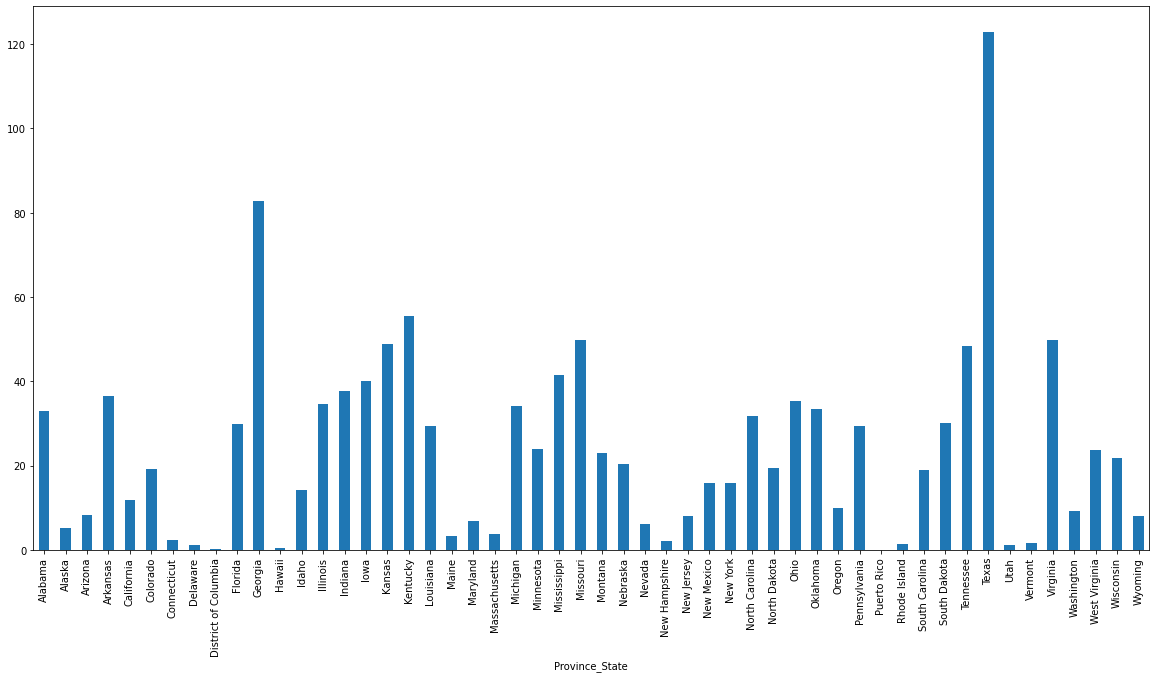

In [9]:
# Add new columns, normalizing by population
df['deaths_per_hundred'] = 100* df['deaths']/df['Population']
df['cases_per_hundred'] = 100* df['cases']/df['Population']

# Since we are dividing, replace any new inf's with nans, then drop those rows (small number)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

# Plot deaths per hundred per state
deaths_per_hundred_per_state = df.groupby('Province_State')['deaths_per_hundred'].sum()
fig = deaths_per_hundred_per_state.plot(kind='bar',figsize=(20, 10))

This shows us that some states, like California, actually have a low number of deaths by their population. Other states, like Texas, still have a high number of deaths when population is taken out (think of deaths or cases per density). Now that we've visualized some of the features, let's look at correlation between these features.

In [10]:
# Print out correlation matrix across all features
df.corr()

,UID,code3,Lat,Long_,Population,deaths,cases,deaths_per_hundred,cases_per_hundred
UID,1.000000,0.999989,0.508367,-0.294993,0.026047,0.047753,0.026946,0.337489,0.068005
code3,0.999989,1.000000,0.508152,-0.295560,0.026299,0.048015,0.027212,0.337637,0.068434
Lat,0.508367,0.508152,1.000000,-0.399295,-0.040581,-0.046753,-0.045426,-0.093732,0.007449
Long_,-0.294993,-0.295560,-0.399295,1.000000,-0.008234,0.026743,-0.001230,0.046534,0.025856
Population,0.026047,0.026299,-0.040581,-0.008234,1.000000,0.952947,0.983187,-0.125287,0.018954
deaths,0.047753,0.048015,-0.046753,0.026743,0.952947,1.000000,0.967303,-0.032045,0.053085
cases,0.026946,0.027212,-0.045426,-0.001230,0.983187,0.967303,1.000000,-0.099909,0.055437
deaths_per_hundred,0.337489,0.337637,-0.093732,0.046534,-0.125287,-0.032045,-0.099909,1.000000,0.281869
cases_per_hundred,0.068005,0.068434,0.007449,0.025856,0.018954,0.053085,0.055437,0.281869,1.000000


Correlation is a metric from 0 to 1 where a high value represents the most correlation. We can see the diagonal ones, which is computing the correlation of features with themselves. What we care about identifying is features correlated with different features. You will notice that this correlation function has removed any categorical variables (like Admin2, which specifies county) and just compares numerical features. From this output, we see that population, deaths, and cases are are highly correlated with each other. However, we see that the normalized versions, deaths_per_hundred and cases_per_hundred, are not highly correlated with each other or with population. Sometimes, you may not want correlated features, because they may not benefit your model. When we go to do our linear regression, we will look at a few different models combining normalized and non-normalized features.

To summarize, in this section we cleaned up the data by merging dataframes, adding some new columns, and removing rows with null values, which were a small percentage of the data. We've visualized some key features like cases and deaths, and compared them over things like states to get a feel for the data set. We've also assessed correlation across features. At this point, there is no indication that we need to transform our data going into our analysis. Next, we will get into our linear regression models.

### Step 4: Perform Analysis Using Supervised Machine Learning Models of your Choice, Present Discussion and Conclusions

Now that we've cleaned and inspected the data, we can get to the supervised machine learning. Let's start with a simple linear regression model between deaths and cases, no matter the state or county. We will use statsmodels to create our linear regression model, and print out a summary of relevant metrics.

In [22]:
# Build a simple ordinary linear regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='deaths ~ cases',data=df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 4.685e+04
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:21:19   Log-Likelihood:                -22604.
No. Observations:                3223   AIC:                         4.521e+04
Df Residuals:                    3221   BIC:                         4.522e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.9320      4.932      5.461      0.0

The first thing we look at are the p values. We see that the p values are all < 0.05, which means that the effect of COVID-19 cases on deaths is statistically significant. This means there is some relationship between these variables, which makes sense. Next, we look at the adjusted R2 values, which is measure of goodness of fit (model accuracy) for linear models. This means that our model does a good job of predicting number of COVID-19 deaths given the COVID-19 cases information. This intuitively makes sense: the more cases, the more people might die from COVID (you also have to have COVID to die from COVID). Let's add in another feature, population, and see how that impacts our model.

In [23]:
# Build a simple ordinary linear regression model
mod = smf.ols(formula='deaths ~ cases + Population',data=df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 2.346e+04
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:21:27   Log-Likelihood:                -22601.
No. Observations:                3223   AIC:                         4.521e+04
Df Residuals:                    3220   BIC:                         4.523e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.1716      4.985      5.049      0.0

What we see now is that the adjusted R2 didn't really change much. So we didn't improve the accuracy of our model even though we added more features. This makes sense, because we think there is some multicollinearity going on, based on the correlation matrix we saw before. Population did not add any information to our model, even though it does have a relationship with deaths (because of it's small p-value). Next, let's look at how our model behaves when we used the normalized features from before.

In [24]:
# Build a simple ordinary linear regression model
mod = smf.ols(formula='deaths_per_hundred ~ cases_per_hundred',data=df).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:     deaths_per_hundred   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     278.0
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           6.23e-60
Time:                        01:22:43   Log-Likelihood:                 1092.7
No. Observations:                3223   AIC:                            -2181.
Df Residuals:                    3221   BIC:                            -2169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2038      0.01

Now with the normalized values, we've essentially removed any population information from our model. But now our adjusted R2 value is very small, which means this model very poorly predicts the number of normalized deaths from normalized cases. This is not good, so we return to our first model, which uses non-normalized cases to predict deaths. We don't need to include the Population feature, since deaths and cases inherently include this information, and adding it to our model does not improve the accuracy (it's redundant information and shows multicollinearity). And even though deaths and cases were correlated, cases were able to accurately predict number of COVID-19 deaths. Last, let's look at our chosen model for just Colorado data, and see if it follows the same trend.

In [27]:
# Build a simple ordinary linear regression model - CO data only
dfCO = df[df['Province_State'] == 'Colorado']
mod = smf.ols(formula='deaths ~ cases',data=dfCO).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     987.4
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           8.54e-40
Time:                        01:31:53   Log-Likelihood:                -385.25
No. Observations:                  64   AIC:                             774.5
Df Residuals:                      62   BIC:                             778.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.2448     14.084      0.940      0.3

The results for the Colorado data set are similar to what we saw with the entire US data set, indicating a high accuracy of the model with a high adjusted R2 value. This indicates that this is likely a good model (predicting COVID-19 deaths from number of cases) across all of the US states, but further research could be done to check this with more OLS models.

### Step 5: Conclusions and Discussion


In this project, we looked at the COVID-19 Johns Hopkins data set which collected number of deaths and cases per state across the US. We first cleaned this data set, by removing null values (and determined that this was ok because nulls were less than 5% of the columns). We also dropped the date columns except for the most recent one, since it was aggregate data, and we were just looking at total number of cases and deaths. We dropped some repetitive columns, like FIPS. Then, we started to visualize the data using bar plots to look at cases and deaths over states. We determined population, deaths, and cases were all highly correlated with each other, so we created some new columns that normalized cases and deaths by population. Next, we looked at some simple linear regression models. It was shown that cases were a strong predictor for deaths across the data set, but multicollinearity might exist. Once we normalized by population, we saw that cases were no longer a strong linear predictor for deaths. This is because both cases and deaths have strong relationships with population, and population information is needed in this model (but not as an added feature seperately, that was multicollinearity). In future work, some things could be investigated further, like does a multiregression model work better here, or some non-linear model? The time series data could also be used, to look at cases and deaths over time. It would also be interesting to combine this data with vaccination data, and see if there are any linear relationships with vaccinations and cases/deaths.